In [ ]:
from projection import ProjectionRegistry

In [ ]:
ProjectionRegistry.list_projections()

In [ ]:
gnomonic_config = ProjectionRegistry.get_projection('gnomonic')

In [ ]:
gnomonic_config.update(shadow_angle=80)

In [ ]:
gnomonic_config

In [ ]:
from projection.registry import ProjectionRegistry
import numpy as np
# Create Mercator projection
mercator_proj = ProjectionRegistry.get_projection("mercator", R=6371, lat_min=-85, lat_max=85)

# Test forward projection
lon = np.array([-180, -90, 0, 90, 180])
lat = np.array([-85, -45, 0, 45, 85])
x, y = mercator_proj.create_projection().forward(lon, lat)
print(f"Forward: x={x}, y={y}")

# Test backward projection
lon_back, lat_back, mask = mercator_proj.create_projection().backward(x, y)
print(f"Backward: lon={lon_back}, lat={lat_back}, mask={mask}")

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install matplotlib

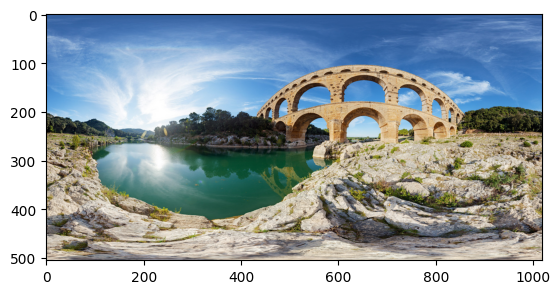

2025-01-15 01:08:24,832 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2025-01-15 01:08:24,833 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2025-01-15 01:08:24,833 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2025-01-15 01:08:24,834 - gnomonic_projection.gnomonic.transform - INFO - GnomonicTransformer initialized successfully.
2025-01-15 01:08:24,834 - gnomonic_projection.processor - INFO - ProjectionProcessor components initialized successfully.
2025-01-15 01:08:24,861 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2025-01-15 01:08:24,861 - gnomonic_projection.processor - INFO - Forward projection completed successfully.
Gnomonic Rectilinear image saved to results/gnomonic_rectilinear.png
2025-01-15 01:08:24,883 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed suc

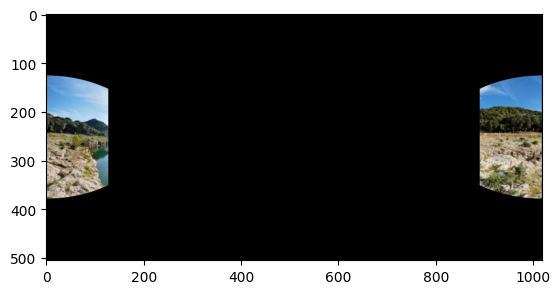

Gnomonic Projection Mean Absolute Error: 99.70602661187426


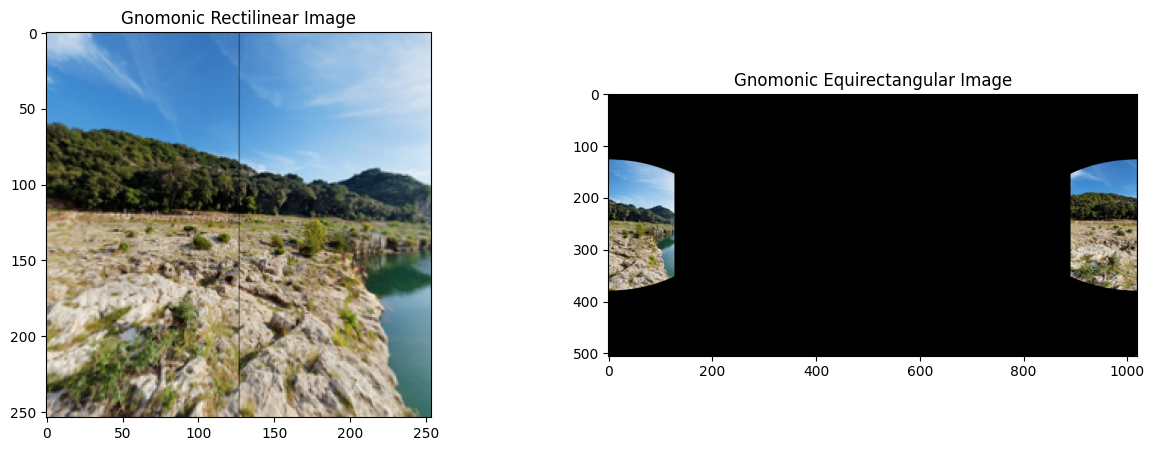

In [3]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_gnomonic_projection(image_path: str, output_dir: str,**kwargs):
    """
    Test the Gnomonic projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)
    plt.imshow(equirect_img )
    plt.show()

    # Step 2: Retrieve and instantiate a Gnomonic projection processor
    processor = ProjectionRegistry.get_projection(
        "gnomonic",
        return_processor=True,
        phi1_deg=0,
        lam0_deg=180,
        lat_points=H,
        lon_points=W,
        x_points=W//4 ,
        y_points=W//4,
        fov_deg=90
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img, **kwargs)
    rectilinear_path = f"{output_dir}/gnomonic_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img, _ = processor.backward(
        rectilinear_img,
        return_mask=True,
        #**kwargs
    )
    equirectangular_path = f"{output_dir}/gnomonic_equirectangular.png"
    #cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    plt.imshow(equirectangular_img)
    plt.show()
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Gnomonic Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Gnomonic Rectilinear Image")
    plt.imshow(rectilinear_img)

    plt.subplot(1, 2, 2)
    plt.title("Gnomonic Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()

kwargs = {
    'delta_lon': 0,
    'delta_lat': 0,
    'shadow_angle': 0,
}
file = "data/image1.png"
#file = "data/eq_sample.png"
test_gnomonic_projection(image_path=file, output_dir="results",**kwargs)

In [ ]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_mercator_projection(image_path: str, output_dir: str,**kwargs):
    """
    Test the Mercator projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)
    plt.imshow(equirect_img)
    plt.show()

    # Step 2: Retrieve and instantiate a Mercator projection processor
    processor = ProjectionRegistry.get_projection(
        "mercator",
        return_processor=True,
        R=1,  # Earth's radius in kilometers
        lon_min=-180,
        lon_max=180,
        lat_min=-85,
        lat_max=85,
        x_points=W,
        y_points=H
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img,**kwargs)
    rectilinear_path = f"{output_dir}/mercator_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img = processor.backward(
        rectilinear_img,
        return_mask=True,
        **kwargs
    )
    equirectangular_path = f"{output_dir}/mercator_equirectangular.png"
    cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Mercator Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Mercator Rectilinear Image")
    plt.imshow(rectilinear_img)
    print(rectilinear_img.max())

    plt.subplot(1, 2, 2)
    plt.title("Mercator Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()
    return rectilinear_img, equirectangular_img, mask


kwargs = {
    'delta_lon': 90,
    'delta_lat': 0,
    'fov_extra': 29.8,
}
file = "data/image1.png"
#file = "data/eq_sample.png"

rectilinear_img , equirectangular_img, mask = test_mercator_projection(image_path=file, output_dir="results", **kwargs)

